In [65]:
import logging
import os
import sys
import shutil
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from glob import glob
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, confusion_matrix

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    CropForegroundd,
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.1.dev2242
Numpy version: 1.23.3
Pytorch version: 1.13.0.dev20220916
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b4720ff5f10303d49466c712c383b53bee529187
MONAI __file__: /Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.10.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/lates

In [66]:
pin_memory = torch.backends.mps.is_available()
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

In [67]:
# Set data directory
in_dir = ''
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/var/folders/48/m3ftszw95q1b2mr64x71lznm0000gn/T/tmpnk3a94nd


In [68]:
df = pd.read_csv('UPENN-GBM_clinical_info_v1.1.csv')

In [69]:
df['IDH1'] = df['IDH1'].astype('category')
df['IDH1'].unique()

['Wildtype', 'NOS/NEC', 'Mutated']
Categories (3, object): ['Mutated', 'NOS/NEC', 'Wildtype']

In [70]:
'''df['IDH1'] = df['IDH1'].replace(['NOS/NEC', 'Mutated'], 0)
df['IDH1'] = df['IDH1'].replace(['Wildtype'], 1)'''

"df['IDH1'] = df['IDH1'].replace(['NOS/NEC', 'Mutated'], 0)\ndf['IDH1'] = df['IDH1'].replace(['Wildtype'], 1)"

In [71]:
df['IDH1'].value_counts()

Wildtype    546
NOS/NEC     106
Mutated      19
Name: IDH1, dtype: int64

In [72]:
df['IDH1'] = df['IDH1'].astype('category')
df['IDH_endoded'] = df['IDH1'].cat.codes

In [73]:
images = sorted(glob(os.path.join(in_dir, "images_structural", "*_T1.nii.gz")))
# 2 binary labels for classification: 0 / 1
labels = df['IDH_endoded']
labels=torch.Tensor(labels).long()
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(labels).float()

In [74]:
len(labels), len(images)

(671, 671)

In [75]:
df['ID'][0], images[0]

('UPENN-GBM-00001_11', 'images_structural/UPENN-GBM-00001_11_T1.nii.gz')

# Model with unsampled data

In [32]:
# Define transforms 
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))]) 
val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

In [33]:
# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:500], labels=labels[:500], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[501:600], labels=labels[501:600], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

# create a Test data loader Warrning 
test_ds = ImageDataset(image_files=images[601:671], labels=labels[601:671], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

<class 'monai.data.meta_tensor.MetaTensor'> (3, 1, 96, 96, 96) tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]) torch.Size([3, 3])


In [76]:
#Setting the model (DenseNet264)
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=3).to(device)

In [77]:
#Setting the model (DenseNet121)
#model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=3).to(device)

In [78]:
# Loss fucntion and Optimizer
#loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-2) #1e-4

In [79]:
#Lowering threshold 
loss_function = torch.nn.CrossEntropyLoss(torch.tensor([1,546/106,546/19]))

In [81]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = (end - start)/60
    print(f"Train time on {device}: {total_time:.3f} mins")
    return total_time

In [18]:
# start a typical PyTorch training
from tqdm.auto import tqdm
train_time_start_on_cpu = timer()

val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 2

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()



# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

----------
epoch 1/5


/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

1/250, train_loss: 32.8944
2/250, train_loss: 27.7111
3/250, train_loss: 0.0003
4/250, train_loss: 33.2812
5/250, train_loss: 0.0008
6/250, train_loss: 0.0002
7/250, train_loss: 65.4089
8/250, train_loss: 0.0000
9/250, train_loss: 0.0000
10/250, train_loss: 0.0000
11/250, train_loss: 34.4734
12/250, train_loss: 0.0018
13/250, train_loss: 17.7916
14/250, train_loss: 0.0139
15/250, train_loss: 0.0195
16/250, train_loss: 0.0044
17/250, train_loss: 53.5111
18/250, train_loss: 0.0001
19/250, train_loss: 43.1527
20/250, train_loss: 0.0002
21/250, train_loss: 31.9205
22/250, train_loss: 14.6258
23/250, train_loss: 0.1450
24/250, train_loss: 17.4781
25/250, train_loss: 12.4108
26/250, train_loss: 8.9150
27/250, train_loss: 8.3517
28/250, train_loss: 20.1896
29/250, train_loss: 9.3183
30/250, train_loss: 8.2341
31/250, train_loss: 5.5073
32/250, train_loss: 1.5166
33/250, train_loss: 0.4515
34/250, train_loss: 0.4815
35/250, train_loss: 0.2188
36/250, train_loss: 8.2188
37/250, train_loss: 0.01

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

1/250, train_loss: 5.0138
2/250, train_loss: 7.4439
3/250, train_loss: 7.9632
4/250, train_loss: 3.1513
5/250, train_loss: 2.3726
6/250, train_loss: 1.8475
7/250, train_loss: 9.1346
8/250, train_loss: 1.0231
9/250, train_loss: 10.4467
10/250, train_loss: 0.7020
11/250, train_loss: 10.7743
12/250, train_loss: 10.0189
13/250, train_loss: 8.7318
14/250, train_loss: 10.7487
15/250, train_loss: 1.2423
16/250, train_loss: 1.5197
17/250, train_loss: 6.1508
18/250, train_loss: 2.5436
19/250, train_loss: 2.5875
20/250, train_loss: 2.1142
21/250, train_loss: 10.7332
22/250, train_loss: 2.2015
23/250, train_loss: 7.4141
24/250, train_loss: 10.0687
25/250, train_loss: 1.4116
26/250, train_loss: 1.3988
27/250, train_loss: 1.3976
28/250, train_loss: 9.0703
29/250, train_loss: 9.7911
30/250, train_loss: 1.1221
31/250, train_loss: 9.1081
32/250, train_loss: 1.3180
33/250, train_loss: 1.1583
34/250, train_loss: 8.4844
35/250, train_loss: 1.3911
36/250, train_loss: 1.2190
37/250, train_loss: 9.0716
38/2

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

saved new best metric model
Current epoch: 2 current accuracy: 0.9697 
Best accuracy: 0.9697 at epoch 2
----------
epoch 3/5


/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

1/250, train_loss: 1.0238
2/250, train_loss: 1.5978
3/250, train_loss: 7.8065
4/250, train_loss: 8.1732
5/250, train_loss: 2.9045
6/250, train_loss: 2.7993
7/250, train_loss: 3.4697
8/250, train_loss: 3.3527
9/250, train_loss: 2.6580
10/250, train_loss: 7.6540
11/250, train_loss: 2.2212
12/250, train_loss: 8.2084
13/250, train_loss: 1.6473
14/250, train_loss: 8.7588
15/250, train_loss: 3.7311
16/250, train_loss: 1.3167
17/250, train_loss: 3.9190
18/250, train_loss: 1.0185
19/250, train_loss: 8.8159
20/250, train_loss: 10.2398
21/250, train_loss: 1.0004
22/250, train_loss: 0.7043
23/250, train_loss: 0.8611
24/250, train_loss: 10.0041
25/250, train_loss: 0.7461
26/250, train_loss: 0.8512
27/250, train_loss: 0.8953
28/250, train_loss: 9.0134
29/250, train_loss: 10.3757
30/250, train_loss: 0.8366
31/250, train_loss: 10.2584
32/250, train_loss: 0.8477
33/250, train_loss: 1.1059
34/250, train_loss: 1.2646
35/250, train_loss: 1.2490
36/250, train_loss: 1.2033
37/250, train_loss: 1.0613
38/250

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

1/250, train_loss: 7.8406
2/250, train_loss: 2.7011
3/250, train_loss: 2.7862
4/250, train_loss: 2.3123
5/250, train_loss: 8.4013
6/250, train_loss: 2.1144
7/250, train_loss: 1.8346
8/250, train_loss: 8.6823
9/250, train_loss: 1.6929
10/250, train_loss: 1.3922
11/250, train_loss: 8.6164
12/250, train_loss: 8.5579
13/250, train_loss: 1.1792
14/250, train_loss: 8.7536
15/250, train_loss: 1.2549
16/250, train_loss: 17.3745
17/250, train_loss: 9.1305
18/250, train_loss: 1.6502
19/250, train_loss: 8.8059
20/250, train_loss: 8.5813
21/250, train_loss: 2.2839
22/250, train_loss: 2.6561
23/250, train_loss: 7.8342
24/250, train_loss: 2.6665
25/250, train_loss: 2.6310
26/250, train_loss: 7.6508
27/250, train_loss: 7.5554
28/250, train_loss: 2.3322
29/250, train_loss: 7.5333
30/250, train_loss: 2.2292
31/250, train_loss: 7.1510
32/250, train_loss: 9.2098
33/250, train_loss: 6.9204
34/250, train_loss: 2.1656
35/250, train_loss: 3.6423
36/250, train_loss: 2.1321
37/250, train_loss: 2.0666
38/250, t

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

Current epoch: 4 current accuracy: 0.9697 
Best accuracy: 0.9697 at epoch 2
----------
epoch 5/5


/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

1/250, train_loss: 7.4458
2/250, train_loss: 2.3416
3/250, train_loss: 2.2633
4/250, train_loss: 2.0867
5/250, train_loss: 1.8563
6/250, train_loss: 1.5845
7/250, train_loss: 8.2120
8/250, train_loss: 11.4330
9/250, train_loss: 16.7174
10/250, train_loss: 7.7126
11/250, train_loss: 7.4683
12/250, train_loss: 1.7002
13/250, train_loss: 9.3486
14/250, train_loss: 1.8888
15/250, train_loss: 1.9970
16/250, train_loss: 2.1966
17/250, train_loss: 9.5520
18/250, train_loss: 2.0858
19/250, train_loss: 9.7255
20/250, train_loss: 1.9269
21/250, train_loss: 1.8999
22/250, train_loss: 1.8855
23/250, train_loss: 15.1477
24/250, train_loss: 1.6485
25/250, train_loss: 1.6993
26/250, train_loss: 1.5132
27/250, train_loss: 1.4232
28/250, train_loss: 8.5931
29/250, train_loss: 1.3114
30/250, train_loss: 1.1160
31/250, train_loss: 1.0514
32/250, train_loss: 8.9103
33/250, train_loss: 0.8701
34/250, train_loss: 10.0336
35/250, train_loss: 0.8739
36/250, train_loss: 0.8246
37/250, train_loss: 0.7520
38/250

## Model Evaluation Merics

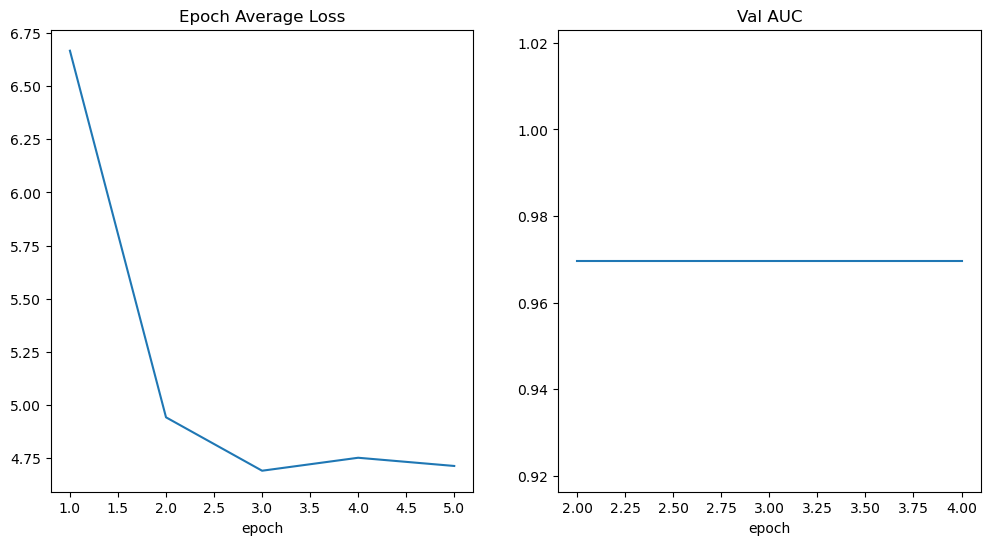

In [27]:
#Plot the loss and metric
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [28]:
'''#Load the best saved model
model.load_state_dict(torch.load(
    os.path.join(in_dir, "best_metric_model_classification3d_array.pth")))'''

<All keys matched successfully>

In [39]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        true = test_labels.argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(true[i].item())
            y_pred.append(pred[i].item())
                            


/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

In [40]:
print(f"\nClassification report:\n\n {classification_report(y_true, y_pred, digits=4)}")


Classification report:

               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         7
           1     0.0000    0.0000    0.0000         2
           2     0.8714    1.0000    0.9313        61

    accuracy                         0.8714        70
   macro avg     0.2905    0.3333    0.3104        70
weighted avg     0.7594    0.8714    0.8116        70



/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

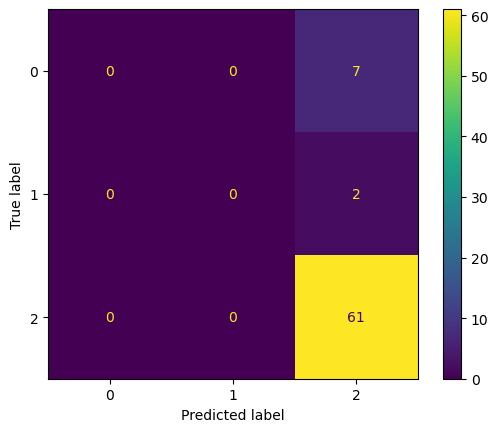

In [41]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Occlusion sensitivity

In [24]:
itera = iter(test_loader)
def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [25]:
# Get a random image and its corresponding label
img, label = get_next_im()

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empt

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.visualize.occlusion_sensitivity OcclusionSensitivity.__init__:stride: Argument `stride` has been deprecated since version 1.0. It will be removed in version 1.2. Please use `overlap`.
  warn_deprecated(argname, msg, warning_category)
100%|█████████████████████████████████████████| 128/128 [01:24<00:00,  1.51it/s]


Train time on cpu: 1.412 mins


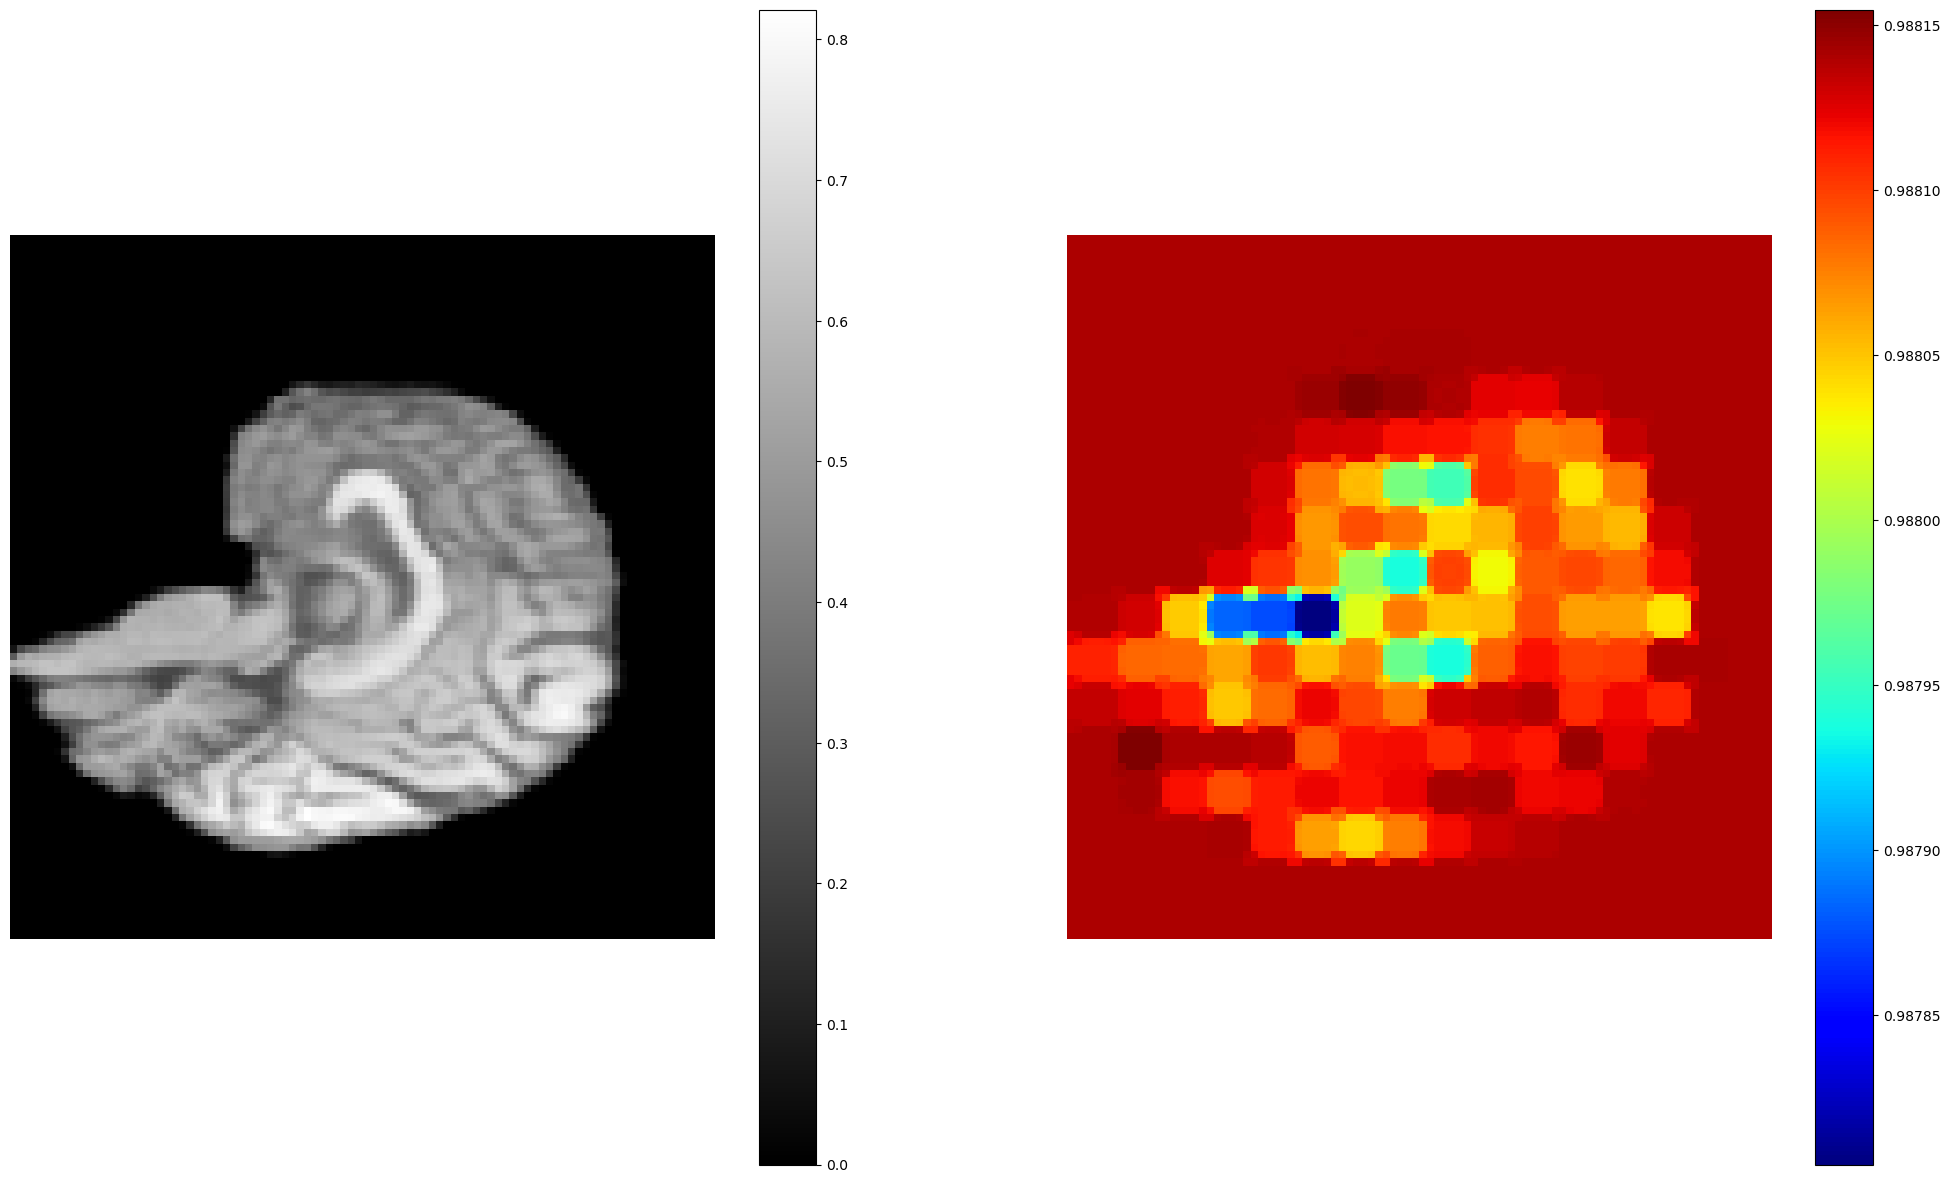

In [26]:
train_time_start_on_cpu = timer()

# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=8, n_batch=2, stride=10)

# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [depth_slice-1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)
    
    
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))    

# ImbalancedDatasetSampler Model

In [142]:
sample_weights = [0] * len(train_ds)
    
for idx, (data, label) in enumerate(train_ds):
        class_weight = class_weights[labels.argmax()]
        sample_weights[idx] = class_weight

In [149]:

sample_weights = [float(i) for i in sample_weights]


In [166]:
labels = df['IDH_endoded']

kwargs = labels[:500]

    
monai.data.DistributedWeightedRandomSampler(dataset=train_ds, weights=sample_weights, 
                                            num_samples_per_rank=None, 
                                            generator=None, even_divisible=True,
                                            num_replicas=None, rank=None, shuffle=True, **kwargs)

TypeError: keywords must be strings

In [121]:
# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:500], labels=labels[:500], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[501:600], labels=labels[501:600], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

# create a Test data loader Warrning 
test_ds = ImageDataset(image_files=images[601:671], labels=labels[601:671], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())

In [137]:
# start a typical PyTorch training
from tqdm.auto import tqdm
train_time_start_on_cpu = timer()

val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 2

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()



# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/2 [00:00<?, ?it/s]

----------
epoch 1/2


FileNotFoundError: No such file: '/Users/ahmedshaheen/Desktop/Glioma Deep learning /images_structural/UPENN-GBM-00078_11'